# Predicting Rail Passenger Miles in the US: Time Series Analysis

Using data from <a href="https://fred.stlouisfed.org/series/RAILPM#0"> FRED </a> ranging from 2000 to 2019, I will forecast and plot values of rail passenger miles for 2020. 

Source: U.S. Bureau of Transportation Statistics, Rail Passenger Miles [RAILPM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RAILPM, July 11, 2020.

In [2]:
#loading libraries
#if needed, use "install.packages("")"
options(warn = -1)
library(ggplot2)
library(tseries)
library(ggfortify)
library(fpp)
library(forecast)
library(patchwork)

#author info
author = "Lukas Barbuscak"
email = "lukas.barbuscak@gmail.com"

In [3]:
#loading the dataset
df = read.csv("data.csv")

#column names
colnames(df)

[1] "DATE"   "RAILPM"

In [4]:
#renaming the columns
names(df)[names(df) == "DATE"] = "date"
names(df)[names(df) == "RAILPM"] = "miles"

In [5]:
#observing the data
head(df)

,date,miles
,<chr>,<int>
1,2000-01-01,366607410
2,2000-02-01,366139276
3,2000-03-01,453096388
4,2000-04-01,473751011
5,2000-05-01,481725263
6,2000-06-01,517102460


In [6]:
#dataset info
str(df)

'data.frame':	240 obs. of  2 variables:
 $ date : chr  "2000-01-01" "2000-02-01" "2000-03-01" "2000-04-01" ...
 $ miles: int  366607410 366139276 453096388 473751011 481725263 517102460 564747276 558060051 446489429 462329685 ...


In [7]:
#changing the "date" column type
df$date = as.Date(df$date)

In [8]:
#summary statistics
summary(df$miles)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
347575222 453075938 515891340 511484121 561248690 681357191 

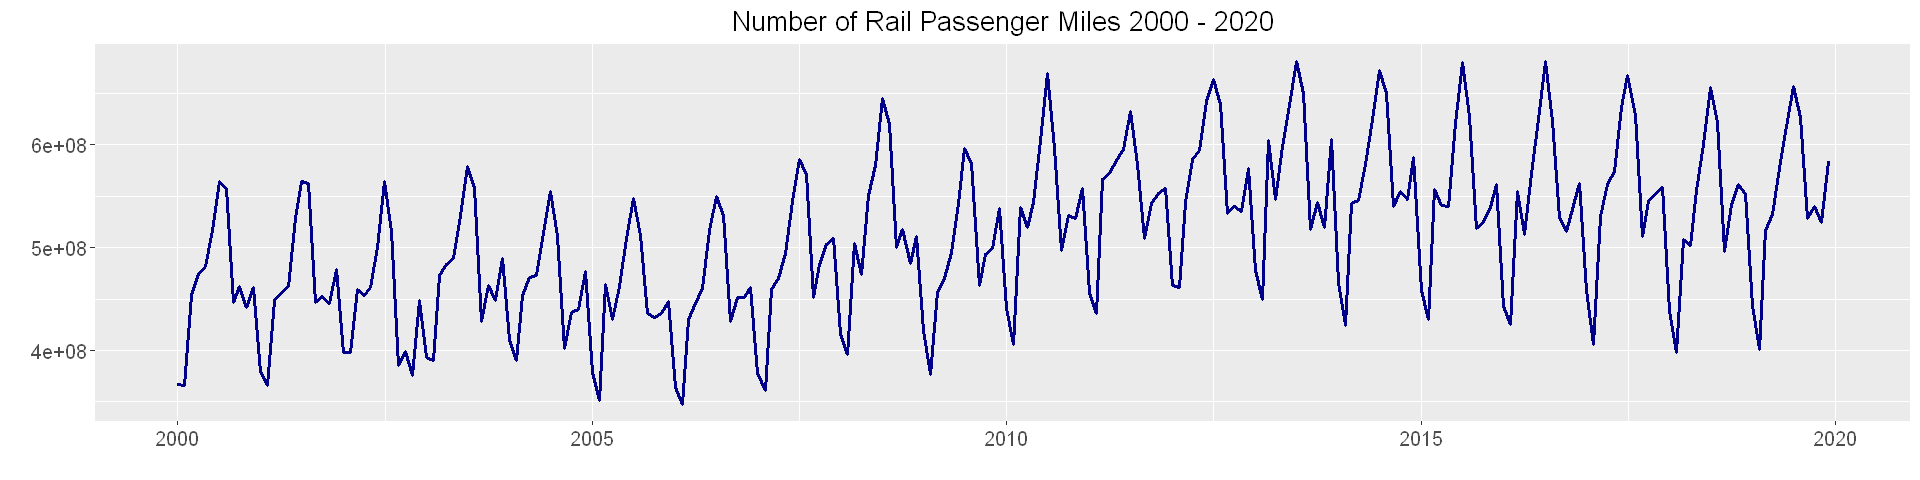

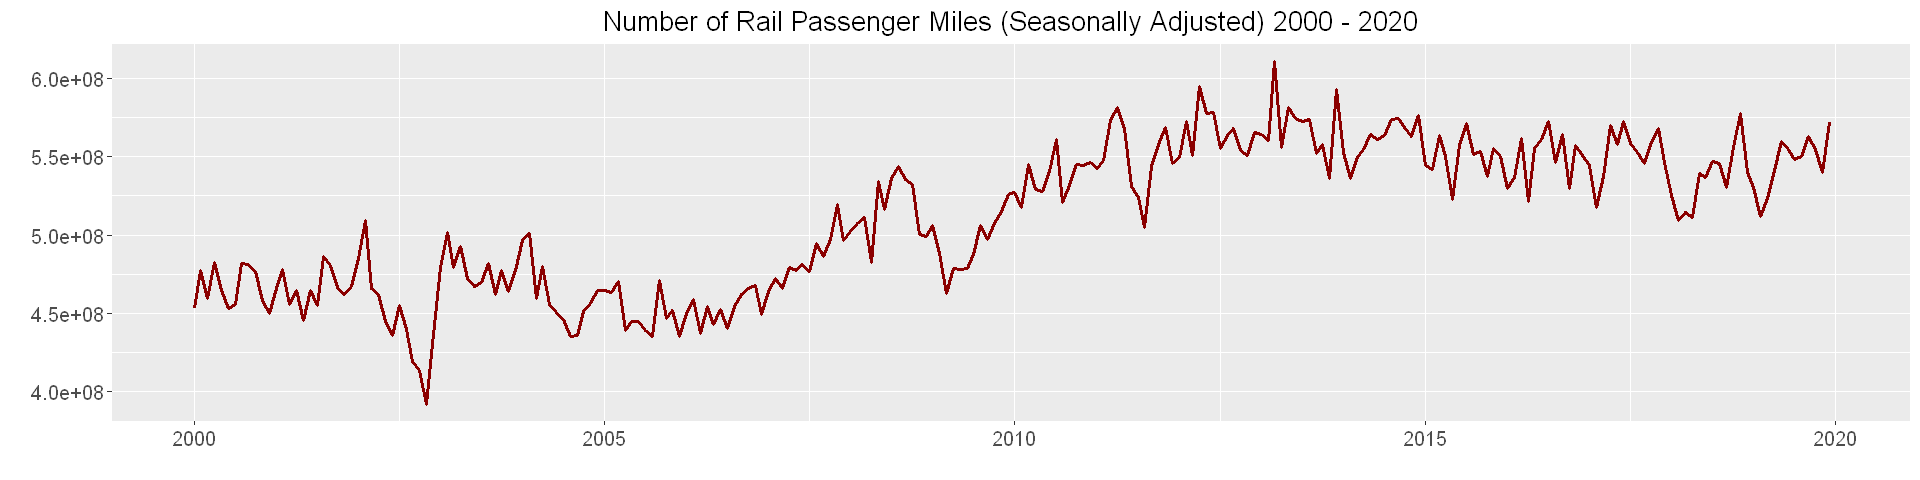

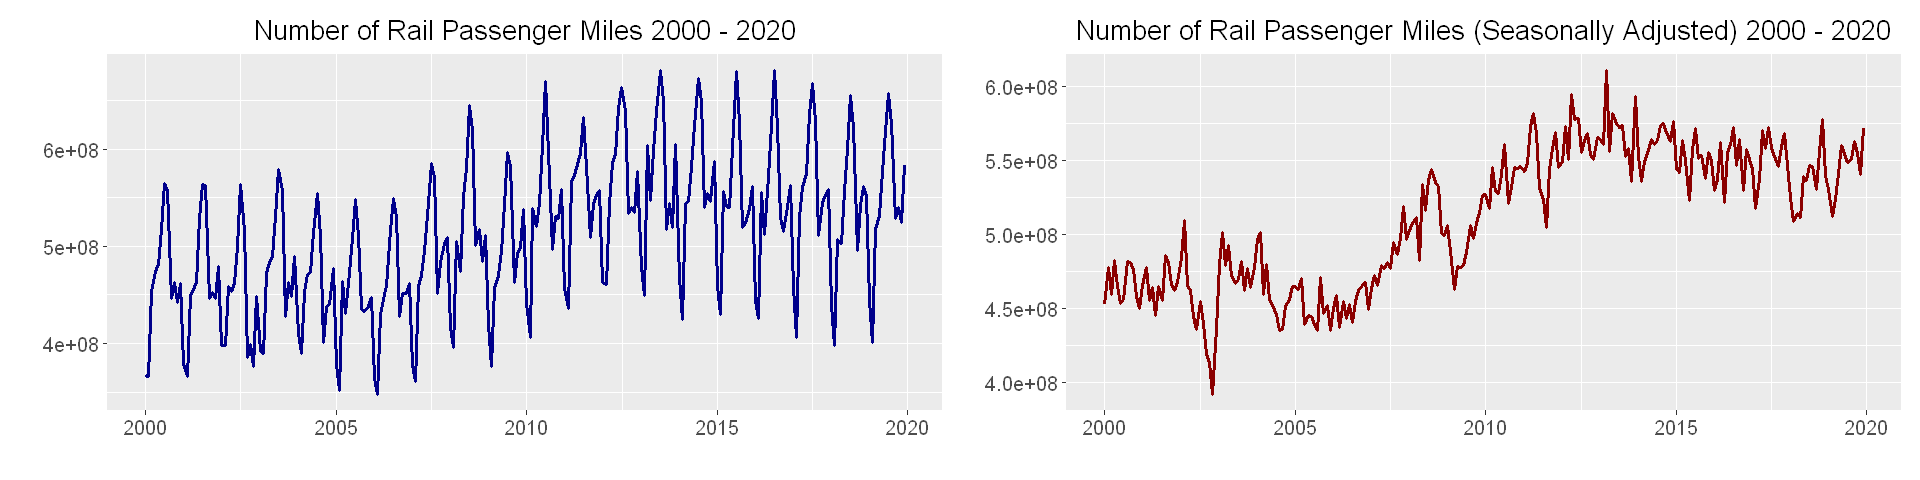

In [9]:
#plotting the data (not seasonally adjusted)
options(repr.plot.width = 16, repr.plot.height = 4)
plot1 = ggplot(data = df, aes(x = date, y = miles))+
          geom_line(color = "darkblue", size=1) +
          labs(title = "Number of Rail Passenger Miles 2000 - 2020",
               x = "", 
               y = "") +
          theme(axis.text=element_text(size=12), 
          plot.title = element_text(hjust = 0.5,size=16))

#creating a time series object
dfts = ts(df[,2], start = c(2000, 1), frequency = 12)

#plotting the data (seasonally adjusted)
decomposed = decompose(dfts, type = c("additive"))
adjusted = dfts - decomposed$seasonal
plot2 = autoplot(adjusted) +
          geom_line(color = "darkred", size=1) +
          labs(title = "Number of Rail Passenger Miles (Seasonally Adjusted) 2000 - 2020",
               x = "", 
               y = "") +
          theme(axis.text=element_text(size=12), 
          plot.title = element_text(hjust = 0.5,size=16))

#displaying the plots
plot1
plot2
plot1 + plot2

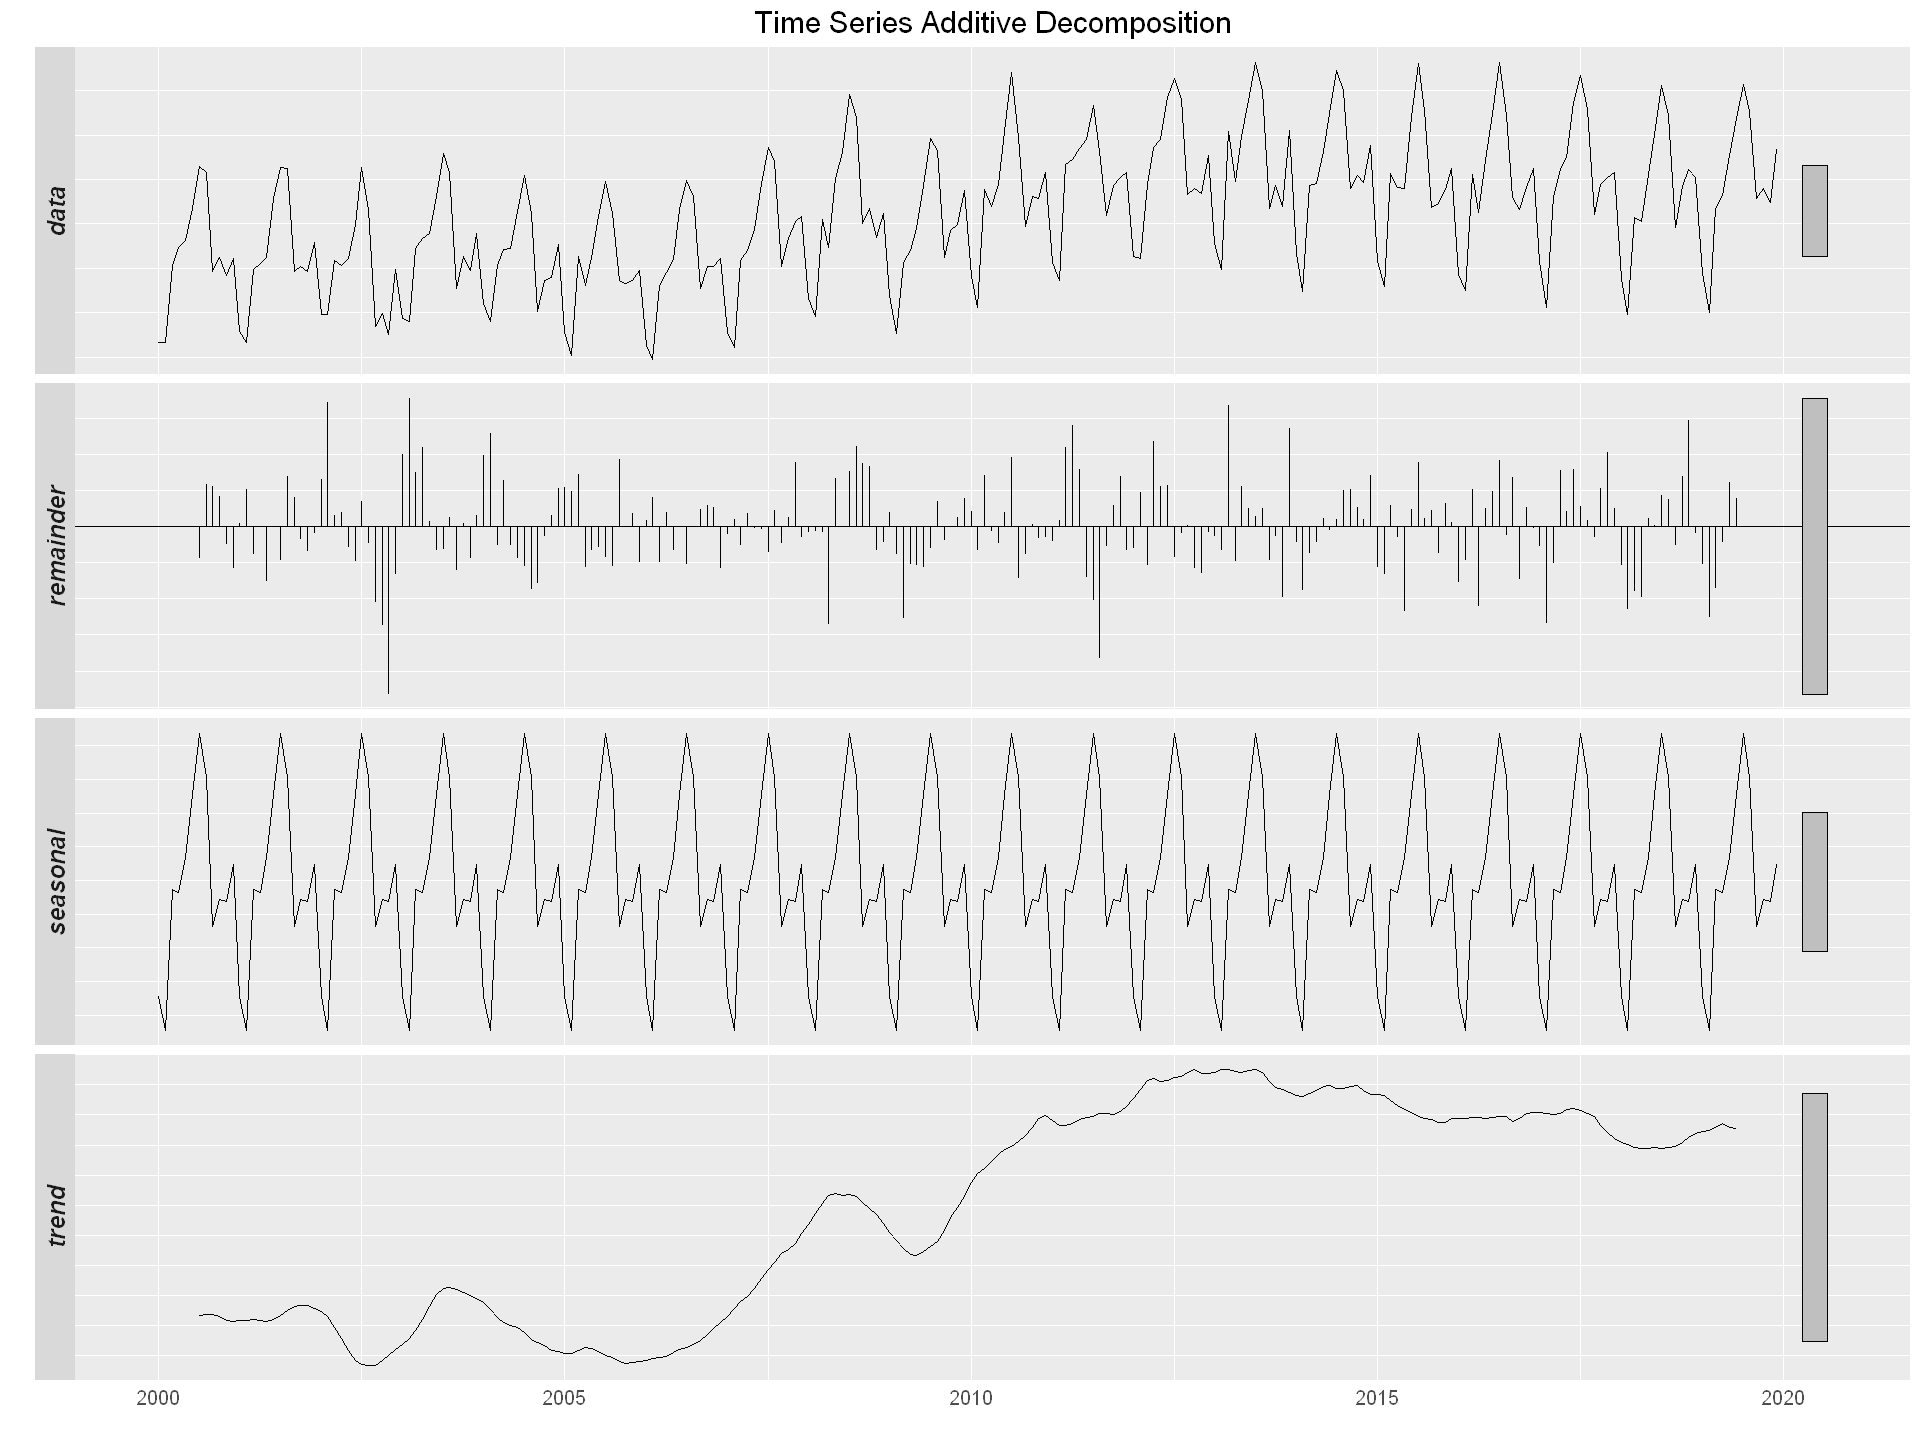

In [10]:
#plotting time series decomposition
options(repr.plot.width = 16, repr.plot.height = 12)
autoplot(decompose(dfts), type = c("additive")) +
  labs(title = "Time Series Additive Decomposition",
               x = "", 
               y = "") +
  theme(axis.text=element_text(size=12), plot.title = element_text(hjust = 0.5, size=18),
       axis.text.y = element_blank(),axis.ticks = element_blank(),
       strip.text.y = element_text(size = 15, face = "bold.italic"))

In [11]:
#performing the D-F test for stationarity
adf.test(dfts,alternative="stationary")


	Augmented Dickey-Fuller Test

data:  dfts
Dickey-Fuller = -6.0121, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


According to the Augmented D-F test, the process is stationary. From the above decomposition, tt is reasonable to expect both AR and MA components to be present. However, we can clearly see that there is some seasonality, so we have to use a seasonal ARIMA model.

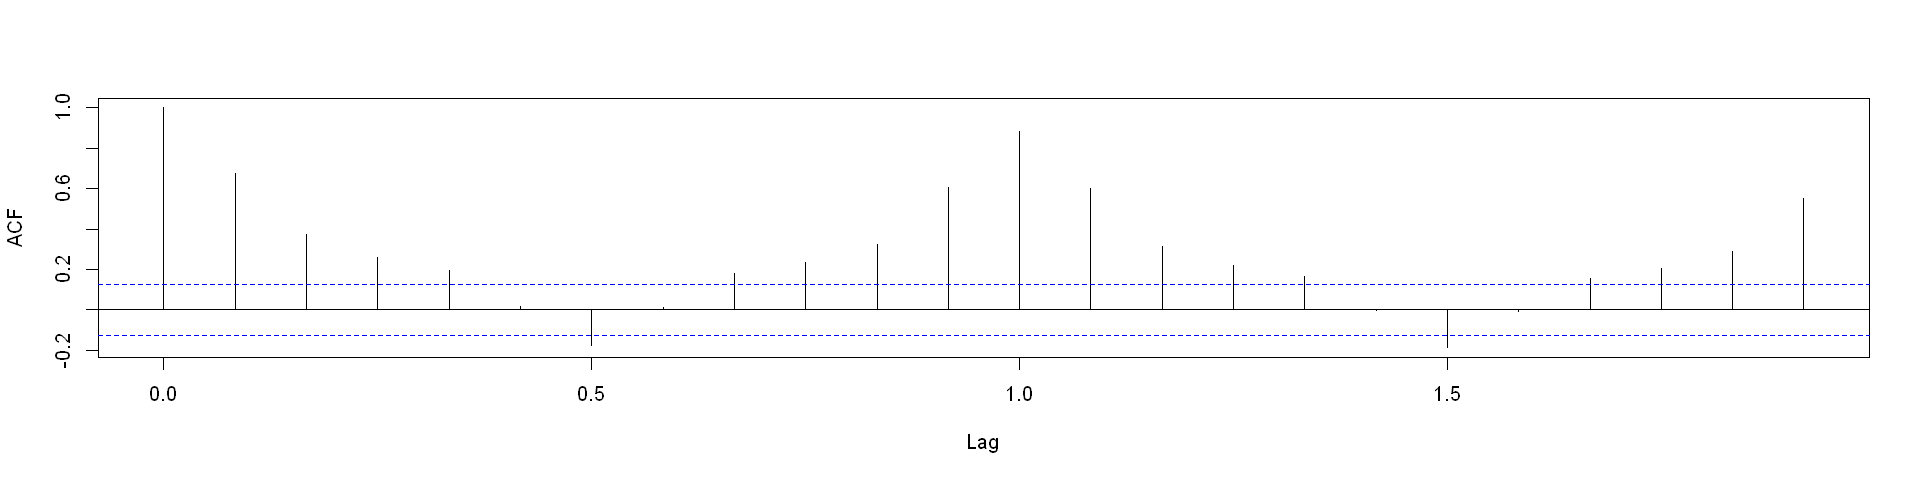

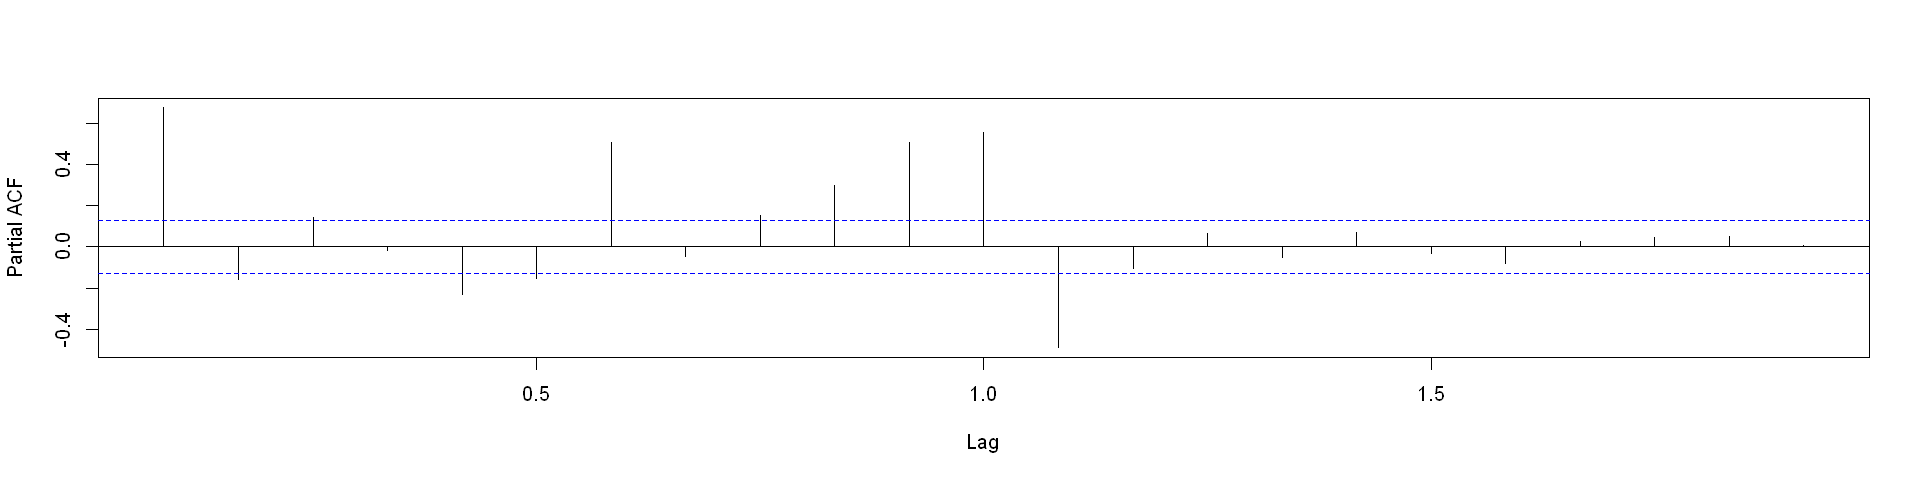

In [12]:
#plotting ACF and PACF
options(repr.plot.width = 16, repr.plot.height = 4)
acf(dfts, main="")
pacf(dfts, main="")

In [13]:
#choosing the best ARIMA model
best = auto.arima(dfts, 
                  stepwise = F, 
                  approximation = F, 
                  trace = T)


 ARIMA(0,0,0)(0,1,0)[12]                    : 8470.21
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 8467.13
 ARIMA(0,0,0)(0,1,1)[12]                    : 8453.402
 ARIMA(0,0,0)(0,1,1)[12] with drift         : 8443.605
 ARIMA(0,0,0)(0,1,2)[12]                    : 8452.589
 ARIMA(0,0,0)(0,1,2)[12] with drift         : 8445.179
 ARIMA(0,0,0)(1,1,0)[12]                    : 8451.649
 ARIMA(0,0,0)(1,1,0)[12] with drift         : 8444.334
 ARIMA(0,0,0)(1,1,1)[12]                    : 8453.659
 ARIMA(0,0,0)(1,1,1)[12] with drift         : 8445.263
 ARIMA(0,0,0)(1,1,2)[12]                    : 8453.446
 ARIMA(0,0,0)(1,1,2)[12] with drift         : 8447.256
 ARIMA(0,0,0)(2,1,0)[12]                    : 8453.632
 ARIMA(0,0,0)(2,1,0)[12] with drift         : 8444.988
 ARIMA(0,0,0)(2,1,1)[12]                    : Inf
 ARIMA(0,0,0)(2,1,1)[12] with drift         : Inf
 ARIMA(0,0,0)(2,1,2)[12]                    : Inf
 ARIMA(0,0,0)(2,1,2)[12] with drift         : Inf
 ARIMA(0,0,1)(0,1,0)[12]       

Not surprisingly, the best ARIMA model has both non-seasonal and seasonal components. The non-seasonal part has no "d" parameter, but the seasonal part has one. There is also drift.

In [14]:
#forecasting for the next 12 months
best
best_forecast = forecast(best, h=12)

Series: dfts 
ARIMA(1,0,1)(0,1,1)[12] with drift 

Coefficients:
         ar1      ma1     sma1     drift
      0.9059  -0.3795  -0.7529  466385.2
s.e.  0.0360   0.0795   0.0521  182908.6

sigma^2 estimated as 3.185e+14:  log likelihood=-4133.74
AIC=8277.49   AICc=8277.76   BIC=8294.63

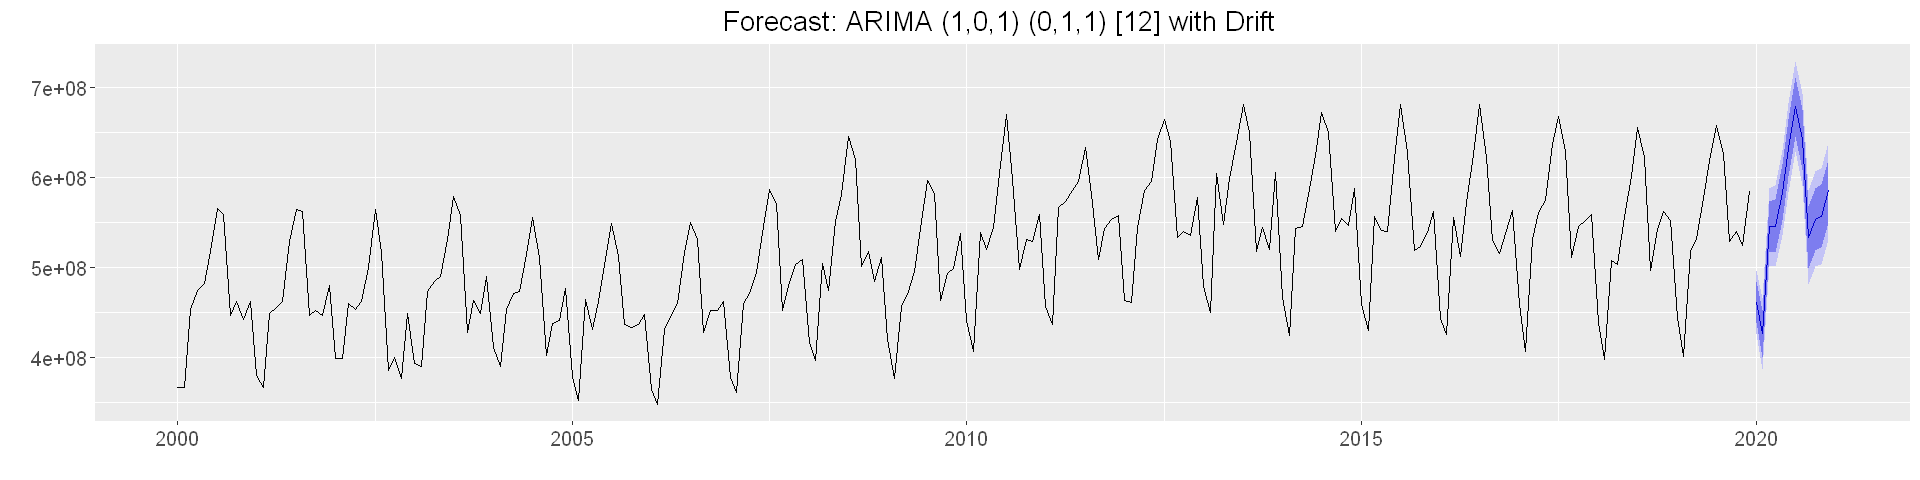

In [15]:
#plotting the forecast
best_plot = autoplot(best_forecast) +
              labs(title = "Forecast: ARIMA (1,0,1) (0,1,1) [12] with Drift ",
                   x = "", 
                   y = "") +
              theme(axis.text=element_text(size=12), 
              plot.title = element_text(hjust = 0.5,size=16))
best_plot

In [16]:
#saving the predictions
write.csv(best_forecast, file = "Rail-Passenger-Miles-Pred.csv", row.names = F)

Using a seasonal ARIMA model, I predicted and plotted values of Rail Passenger Miles for the year 2020, and I saved the predictions to a .csv file. Future iterations of this time series analysis can introduce additional variables for a multivariate analysis, and can analyse the impact of the current recession on the transportation sector.